In [1]:
%pylab inline
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LogisticRegression
import clustering as cl
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk', rc={ 'lines.linewidth': 6}, font_scale=1.5)

In [3]:
X_with_columns = pd.read_pickle("pickle_files/X.pkl")
Z_with_columns = pd.read_pickle("pickle_files/Z.pkl")

columns_to_drop = []

X_with_columns.drop(columns_to_drop, axis = 1, inplace=True)
Z_with_columns.drop(columns_to_drop, axis = 1, inplace=True)

X = np.array(X_with_columns)
Y = np.array(pd.read_pickle("pickle_files/Y.pkl"))
Z = np.array(Z_with_columns)
df_next_games = pd.read_pickle("pickle_files/next_games.pkl")

In [4]:
kf = KFold(n_splits=4, random_state=0, shuffle=True)
kf.get_n_splits(X)

4

In [5]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

TRAIN: [   0    2    3    4    6    7    9   11   12   13   16   17   19   20
   21   22   23   24   25   26   28   29   30   32   33   35   36   37
   38   40   41   42   43   44   46   47   48   50   51   53   54   56
   57   59   61   62   63   65   66   67   68   69   71   72   73   74
   76   78   79   80   83   84   86   87   88   89   90   91   92   93
   94   95   96   98   99  100  101  102  104  105  106  107  109  110
  111  112  113  114  115  116  117  118  119  120  121  123  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  143
  144  145  146  147  148  149  150  151  153  154  155  157  158  160
  162  163  164  165  166  167  168  169  170  171  172  173  174  176
  177  178  179  180  181  182  185  188  189  190  191  193  195  197
  199  200  201  203  205  206  207  208  209  210  212  213  214  215
  216  217  218  219  220  221  222  223  225  226  227  228  229  230
  232  234  235  236  237  238  239  241  242  243  244  245  246  248

## XGBoost

In [6]:
XGB_model = xgb.XGBClassifier(silent=False, 
                      learning_rate=0.005,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      n_estimators=1000, 
                      reg_alpha = 0.2,
                      reg_lambda = .5,
                      max_depth=5, 
                      gamma=5,
                      seed=82)

In [7]:
eval_set = [(X_train, y_train), (X_test, y_test)]

XGB_model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
y_pred = XGB_model.predict(X_test)
y_pred_train = XGB_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

[12:45:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-merror:0.34547	validation_0-mlogloss:1.09676	validation_1-merror:0.38538	validation_1-mlogloss:1.09699
[1]	validation_0-merror:0.33996	validation_0-mlogloss:1.09451	validation_1-merror:0.35880	validation_1-mlogloss:1.09498
[2]	validation_0-merror:0.30684	validation_0-mlogloss:1.09197	validation_1-merror:0.36213	validation_1-mlogloss:1.09301
[3]	validation_0-merror:0.28587	validation_0-mlogloss:1.08948	validation_1-merror:0.35216	validation_1-mlogloss:1.09091
[4]	validation_0-merror:0.28808	validation_0-mlogloss:1.08751	validation_1-merror:0.35216	validation_1-mlogloss:1.08915
[5]	validation_0-merror:0.27925	validation_0

[65]	validation_0-merror:0.27373	validation_0-mlogloss:0.96643	validation_1-merror:0.33223	validation_1-mlogloss:0.98889
[66]	validation_0-merror:0.27373	validation_0-mlogloss:0.96483	validation_1-merror:0.33223	validation_1-mlogloss:0.98764
[67]	validation_0-merror:0.27925	validation_0-mlogloss:0.96328	validation_1-merror:0.33555	validation_1-mlogloss:0.98623
[68]	validation_0-merror:0.27704	validation_0-mlogloss:0.96192	validation_1-merror:0.33223	validation_1-mlogloss:0.98522
[69]	validation_0-merror:0.27704	validation_0-mlogloss:0.96028	validation_1-merror:0.33223	validation_1-mlogloss:0.98387
[70]	validation_0-merror:0.27815	validation_0-mlogloss:0.95875	validation_1-merror:0.33555	validation_1-mlogloss:0.98264
[71]	validation_0-merror:0.27704	validation_0-mlogloss:0.95703	validation_1-merror:0.33223	validation_1-mlogloss:0.98130
[72]	validation_0-merror:0.27815	validation_0-mlogloss:0.95595	validation_1-merror:0.33223	validation_1-mlogloss:0.98054
[73]	validation_0-merror:0.27815

[133]	validation_0-merror:0.27815	validation_0-mlogloss:0.87845	validation_1-merror:0.33223	validation_1-mlogloss:0.91763
[134]	validation_0-merror:0.27815	validation_0-mlogloss:0.87719	validation_1-merror:0.32890	validation_1-mlogloss:0.91657
[135]	validation_0-merror:0.27925	validation_0-mlogloss:0.87598	validation_1-merror:0.32890	validation_1-mlogloss:0.91552
[136]	validation_0-merror:0.27925	validation_0-mlogloss:0.87506	validation_1-merror:0.32890	validation_1-mlogloss:0.91474
[137]	validation_0-merror:0.27815	validation_0-mlogloss:0.87367	validation_1-merror:0.32890	validation_1-mlogloss:0.91386
[138]	validation_0-merror:0.27925	validation_0-mlogloss:0.87291	validation_1-merror:0.32890	validation_1-mlogloss:0.91313
[139]	validation_0-merror:0.27925	validation_0-mlogloss:0.87162	validation_1-merror:0.32890	validation_1-mlogloss:0.91211
[140]	validation_0-merror:0.27925	validation_0-mlogloss:0.87063	validation_1-merror:0.32890	validation_1-mlogloss:0.91141
[141]	validation_0-merro

[201]	validation_0-merror:0.27594	validation_0-mlogloss:0.81397	validation_1-merror:0.32558	validation_1-mlogloss:0.86712
[202]	validation_0-merror:0.27594	validation_0-mlogloss:0.81297	validation_1-merror:0.32558	validation_1-mlogloss:0.86639
[203]	validation_0-merror:0.27594	validation_0-mlogloss:0.81212	validation_1-merror:0.32558	validation_1-mlogloss:0.86575
[204]	validation_0-merror:0.27704	validation_0-mlogloss:0.81118	validation_1-merror:0.32558	validation_1-mlogloss:0.86509
[205]	validation_0-merror:0.27815	validation_0-mlogloss:0.81061	validation_1-merror:0.32558	validation_1-mlogloss:0.86466
[206]	validation_0-merror:0.27815	validation_0-mlogloss:0.80985	validation_1-merror:0.32558	validation_1-mlogloss:0.86394
[207]	validation_0-merror:0.27925	validation_0-mlogloss:0.80901	validation_1-merror:0.32558	validation_1-mlogloss:0.86337
[208]	validation_0-merror:0.27925	validation_0-mlogloss:0.80801	validation_1-merror:0.32558	validation_1-mlogloss:0.86254
[209]	validation_0-merro

[269]	validation_0-merror:0.27373	validation_0-mlogloss:0.76658	validation_1-merror:0.32226	validation_1-mlogloss:0.83157
[270]	validation_0-merror:0.27373	validation_0-mlogloss:0.76600	validation_1-merror:0.32226	validation_1-mlogloss:0.83114
[271]	validation_0-merror:0.27263	validation_0-mlogloss:0.76551	validation_1-merror:0.32558	validation_1-mlogloss:0.83073
[272]	validation_0-merror:0.27263	validation_0-mlogloss:0.76466	validation_1-merror:0.32558	validation_1-mlogloss:0.83020
[273]	validation_0-merror:0.27152	validation_0-mlogloss:0.76405	validation_1-merror:0.32558	validation_1-mlogloss:0.82968
[274]	validation_0-merror:0.27152	validation_0-mlogloss:0.76348	validation_1-merror:0.32558	validation_1-mlogloss:0.82917
[275]	validation_0-merror:0.27042	validation_0-mlogloss:0.76278	validation_1-merror:0.32558	validation_1-mlogloss:0.82866
[276]	validation_0-merror:0.27042	validation_0-mlogloss:0.76205	validation_1-merror:0.32558	validation_1-mlogloss:0.82823
[277]	validation_0-merro

[337]	validation_0-merror:0.26269	validation_0-mlogloss:0.73082	validation_1-merror:0.32226	validation_1-mlogloss:0.80499
[338]	validation_0-merror:0.26159	validation_0-mlogloss:0.73028	validation_1-merror:0.32226	validation_1-mlogloss:0.80452
[339]	validation_0-merror:0.26269	validation_0-mlogloss:0.72978	validation_1-merror:0.32226	validation_1-mlogloss:0.80410
[340]	validation_0-merror:0.26269	validation_0-mlogloss:0.72937	validation_1-merror:0.32226	validation_1-mlogloss:0.80375
[341]	validation_0-merror:0.26269	validation_0-mlogloss:0.72891	validation_1-merror:0.32226	validation_1-mlogloss:0.80334
[342]	validation_0-merror:0.26269	validation_0-mlogloss:0.72864	validation_1-merror:0.32226	validation_1-mlogloss:0.80315
[343]	validation_0-merror:0.26159	validation_0-mlogloss:0.72816	validation_1-merror:0.32226	validation_1-mlogloss:0.80282
[344]	validation_0-merror:0.26159	validation_0-mlogloss:0.72799	validation_1-merror:0.32226	validation_1-mlogloss:0.80268
[345]	validation_0-merro

[405]	validation_0-merror:0.26049	validation_0-mlogloss:0.70421	validation_1-merror:0.32226	validation_1-mlogloss:0.78575
[406]	validation_0-merror:0.25938	validation_0-mlogloss:0.70385	validation_1-merror:0.32558	validation_1-mlogloss:0.78556
[407]	validation_0-merror:0.25938	validation_0-mlogloss:0.70334	validation_1-merror:0.32558	validation_1-mlogloss:0.78515
[408]	validation_0-merror:0.25938	validation_0-mlogloss:0.70317	validation_1-merror:0.32558	validation_1-mlogloss:0.78502
[409]	validation_0-merror:0.25938	validation_0-mlogloss:0.70284	validation_1-merror:0.32226	validation_1-mlogloss:0.78482
[410]	validation_0-merror:0.25938	validation_0-mlogloss:0.70244	validation_1-merror:0.32226	validation_1-mlogloss:0.78445
[411]	validation_0-merror:0.25938	validation_0-mlogloss:0.70220	validation_1-merror:0.32226	validation_1-mlogloss:0.78430
[412]	validation_0-merror:0.25938	validation_0-mlogloss:0.70185	validation_1-merror:0.32226	validation_1-mlogloss:0.78410
[413]	validation_0-merro

[473]	validation_0-merror:0.25717	validation_0-mlogloss:0.68256	validation_1-merror:0.31894	validation_1-mlogloss:0.77163
[474]	validation_0-merror:0.25828	validation_0-mlogloss:0.68235	validation_1-merror:0.31894	validation_1-mlogloss:0.77142
[475]	validation_0-merror:0.25717	validation_0-mlogloss:0.68205	validation_1-merror:0.31894	validation_1-mlogloss:0.77123
[476]	validation_0-merror:0.25717	validation_0-mlogloss:0.68195	validation_1-merror:0.31894	validation_1-mlogloss:0.77119
[477]	validation_0-merror:0.25717	validation_0-mlogloss:0.68164	validation_1-merror:0.31894	validation_1-mlogloss:0.77095
[478]	validation_0-merror:0.25717	validation_0-mlogloss:0.68120	validation_1-merror:0.31894	validation_1-mlogloss:0.77065
[479]	validation_0-merror:0.25717	validation_0-mlogloss:0.68102	validation_1-merror:0.31894	validation_1-mlogloss:0.77051
[480]	validation_0-merror:0.25828	validation_0-mlogloss:0.68075	validation_1-merror:0.31894	validation_1-mlogloss:0.77034
[481]	validation_0-merro

[541]	validation_0-merror:0.25607	validation_0-mlogloss:0.66625	validation_1-merror:0.32226	validation_1-mlogloss:0.76074
[542]	validation_0-merror:0.25607	validation_0-mlogloss:0.66604	validation_1-merror:0.32226	validation_1-mlogloss:0.76062
[543]	validation_0-merror:0.25497	validation_0-mlogloss:0.66582	validation_1-merror:0.32226	validation_1-mlogloss:0.76040
[544]	validation_0-merror:0.25386	validation_0-mlogloss:0.66549	validation_1-merror:0.31894	validation_1-mlogloss:0.76014
[545]	validation_0-merror:0.25386	validation_0-mlogloss:0.66541	validation_1-merror:0.31894	validation_1-mlogloss:0.76006
[546]	validation_0-merror:0.25386	validation_0-mlogloss:0.66516	validation_1-merror:0.31894	validation_1-mlogloss:0.75989
[547]	validation_0-merror:0.25607	validation_0-mlogloss:0.66497	validation_1-merror:0.31894	validation_1-mlogloss:0.75977
[548]	validation_0-merror:0.25607	validation_0-mlogloss:0.66488	validation_1-merror:0.31894	validation_1-mlogloss:0.75970
[549]	validation_0-merro

[609]	validation_0-merror:0.25055	validation_0-mlogloss:0.65358	validation_1-merror:0.32226	validation_1-mlogloss:0.75224
[610]	validation_0-merror:0.25276	validation_0-mlogloss:0.65335	validation_1-merror:0.32226	validation_1-mlogloss:0.75214
[611]	validation_0-merror:0.25055	validation_0-mlogloss:0.65327	validation_1-merror:0.32226	validation_1-mlogloss:0.75207
[612]	validation_0-merror:0.25166	validation_0-mlogloss:0.65300	validation_1-merror:0.32226	validation_1-mlogloss:0.75192
[613]	validation_0-merror:0.25166	validation_0-mlogloss:0.65288	validation_1-merror:0.32226	validation_1-mlogloss:0.75184
[614]	validation_0-merror:0.25055	validation_0-mlogloss:0.65268	validation_1-merror:0.32226	validation_1-mlogloss:0.75168
[615]	validation_0-merror:0.25166	validation_0-mlogloss:0.65265	validation_1-merror:0.32226	validation_1-mlogloss:0.75165
[616]	validation_0-merror:0.25055	validation_0-mlogloss:0.65248	validation_1-merror:0.32226	validation_1-mlogloss:0.75147
[617]	validation_0-merro

[677]	validation_0-merror:0.24724	validation_0-mlogloss:0.64273	validation_1-merror:0.32226	validation_1-mlogloss:0.74490
[678]	validation_0-merror:0.24614	validation_0-mlogloss:0.64264	validation_1-merror:0.32226	validation_1-mlogloss:0.74488
[679]	validation_0-merror:0.24834	validation_0-mlogloss:0.64252	validation_1-merror:0.32226	validation_1-mlogloss:0.74487
[680]	validation_0-merror:0.24834	validation_0-mlogloss:0.64236	validation_1-merror:0.32226	validation_1-mlogloss:0.74479
[681]	validation_0-merror:0.24834	validation_0-mlogloss:0.64220	validation_1-merror:0.32226	validation_1-mlogloss:0.74476
[682]	validation_0-merror:0.24834	validation_0-mlogloss:0.64211	validation_1-merror:0.32226	validation_1-mlogloss:0.74464
[683]	validation_0-merror:0.24834	validation_0-mlogloss:0.64200	validation_1-merror:0.32226	validation_1-mlogloss:0.74454
[684]	validation_0-merror:0.24724	validation_0-mlogloss:0.64196	validation_1-merror:0.32226	validation_1-mlogloss:0.74451
[685]	validation_0-merro

[745]	validation_0-merror:0.24503	validation_0-mlogloss:0.63544	validation_1-merror:0.32226	validation_1-mlogloss:0.74046
[746]	validation_0-merror:0.24393	validation_0-mlogloss:0.63512	validation_1-merror:0.32226	validation_1-mlogloss:0.74024
[747]	validation_0-merror:0.24503	validation_0-mlogloss:0.63494	validation_1-merror:0.32226	validation_1-mlogloss:0.74003
[748]	validation_0-merror:0.24503	validation_0-mlogloss:0.63492	validation_1-merror:0.32226	validation_1-mlogloss:0.74002
[749]	validation_0-merror:0.24503	validation_0-mlogloss:0.63486	validation_1-merror:0.32226	validation_1-mlogloss:0.73996
[750]	validation_0-merror:0.24393	validation_0-mlogloss:0.63474	validation_1-merror:0.32226	validation_1-mlogloss:0.73993
[751]	validation_0-merror:0.24393	validation_0-mlogloss:0.63470	validation_1-merror:0.32226	validation_1-mlogloss:0.73991
[752]	validation_0-merror:0.24283	validation_0-mlogloss:0.63456	validation_1-merror:0.32226	validation_1-mlogloss:0.73982
[753]	validation_0-merro

[813]	validation_0-merror:0.24062	validation_0-mlogloss:0.62695	validation_1-merror:0.32226	validation_1-mlogloss:0.73537
[814]	validation_0-merror:0.24062	validation_0-mlogloss:0.62695	validation_1-merror:0.32226	validation_1-mlogloss:0.73537
[815]	validation_0-merror:0.24062	validation_0-mlogloss:0.62687	validation_1-merror:0.32226	validation_1-mlogloss:0.73538
[816]	validation_0-merror:0.24062	validation_0-mlogloss:0.62674	validation_1-merror:0.32226	validation_1-mlogloss:0.73533
[817]	validation_0-merror:0.24062	validation_0-mlogloss:0.62658	validation_1-merror:0.32226	validation_1-mlogloss:0.73521
[818]	validation_0-merror:0.24062	validation_0-mlogloss:0.62641	validation_1-merror:0.32226	validation_1-mlogloss:0.73508
[819]	validation_0-merror:0.24062	validation_0-mlogloss:0.62632	validation_1-merror:0.32226	validation_1-mlogloss:0.73503
[820]	validation_0-merror:0.24062	validation_0-mlogloss:0.62632	validation_1-merror:0.32226	validation_1-mlogloss:0.73504
[821]	validation_0-merro

[881]	validation_0-merror:0.24172	validation_0-mlogloss:0.62026	validation_1-merror:0.32226	validation_1-mlogloss:0.73191
[882]	validation_0-merror:0.24172	validation_0-mlogloss:0.62018	validation_1-merror:0.32226	validation_1-mlogloss:0.73183
[883]	validation_0-merror:0.24172	validation_0-mlogloss:0.62008	validation_1-merror:0.32226	validation_1-mlogloss:0.73175
[884]	validation_0-merror:0.24172	validation_0-mlogloss:0.61994	validation_1-merror:0.32226	validation_1-mlogloss:0.73166
[885]	validation_0-merror:0.24172	validation_0-mlogloss:0.61991	validation_1-merror:0.32226	validation_1-mlogloss:0.73166
[886]	validation_0-merror:0.24172	validation_0-mlogloss:0.61983	validation_1-merror:0.32226	validation_1-mlogloss:0.73167
[887]	validation_0-merror:0.24172	validation_0-mlogloss:0.61983	validation_1-merror:0.32226	validation_1-mlogloss:0.73167
[888]	validation_0-merror:0.24062	validation_0-mlogloss:0.61970	validation_1-merror:0.32226	validation_1-mlogloss:0.73163
[889]	validation_0-merro

[949]	validation_0-merror:0.23951	validation_0-mlogloss:0.61531	validation_1-merror:0.32226	validation_1-mlogloss:0.72913
[950]	validation_0-merror:0.23841	validation_0-mlogloss:0.61531	validation_1-merror:0.32226	validation_1-mlogloss:0.72913
[951]	validation_0-merror:0.23951	validation_0-mlogloss:0.61531	validation_1-merror:0.32226	validation_1-mlogloss:0.72914
[952]	validation_0-merror:0.23841	validation_0-mlogloss:0.61519	validation_1-merror:0.32226	validation_1-mlogloss:0.72905
[953]	validation_0-merror:0.23841	validation_0-mlogloss:0.61511	validation_1-merror:0.32226	validation_1-mlogloss:0.72899
[954]	validation_0-merror:0.23951	validation_0-mlogloss:0.61499	validation_1-merror:0.32226	validation_1-mlogloss:0.72890
[955]	validation_0-merror:0.23951	validation_0-mlogloss:0.61490	validation_1-merror:0.32226	validation_1-mlogloss:0.72878
[956]	validation_0-merror:0.23951	validation_0-mlogloss:0.61490	validation_1-merror:0.32226	validation_1-mlogloss:0.72878
[957]	validation_0-merro

In [8]:
y_pred.shape

(301,)

In [9]:
pd.Series(y_pred).value_counts()

3.0    192
1.0     94
2.0     15
dtype: int64

## LogisticRegression

In [10]:
LR = LogisticRegression(random_state = 42)
LR.fit(X_train, y_train)
LR_y_pred = LR.predict(X_test)
LR_y_pred_train = LR.predict(X_train)
LR_accuracy = accuracy_score(y_test, LR_y_pred)
LR_accuracy_train = accuracy_score(y_train, LR_y_pred_train)

In [11]:
pd.Series(LR_y_pred).value_counts()

3.0    168
1.0    102
2.0     31
dtype: int64

## Comparassion

In [12]:
print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))
print("LR train Accuracy: %.2f%%" % (LR_accuracy_train * 100.0))
print("LR Accuracy: %.2f%%" % (LR_accuracy * 100.0))

XGB train Accuracy: 76.27%
XGB Accuracy: 67.44%
LR train Accuracy: 76.27%
LR Accuracy: 72.43%


In [13]:
features_names = list(X_with_columns.columns)

In [14]:
importance = np.round(XGB_model.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:35} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGATGDIFF                          4.66%
Feature Importance: AVGHTGDIFF                          4.12%
Feature Importance: odds_ft_away_team_win               3.91%
Feature Importance: odds_ft_home_team_win               3.84%
Feature Importance: away_ppg                            3.38%
Feature Importance: odds_ft_draw                        3.14%
Feature Importance: odds_ft_over25                      2.79%
Feature Importance: home_ppg                            2.75%
Feature Importance: awt_3                               2.72%
Feature Importance: H_AVGHTGDIFF_1                      2.46%
Feature Importance: A_AVGATGDIFF_1                      2.36%
Feature Importance: ht_3                                2.28%
Feature Importance: odds_btts_no                        2.25%
Feature Importance: A_result_1                          2.12%
Feature Importance: attendance                          2.07%
Feature Importance: Pre-Match PPG (Home)                2.05%
Feature 

In [15]:
cum_values = np.cumsum(values)
values_over_95 = (cum_values > 95).sum()
columns_over_95 = names[-values_over_95:]
columns_over_95

['btts_percentage_pre_match',
 'ht_1',
 'average_corners_per_match_pre_match',
 'odds_ft_over45',
 'odds_ft_over35']

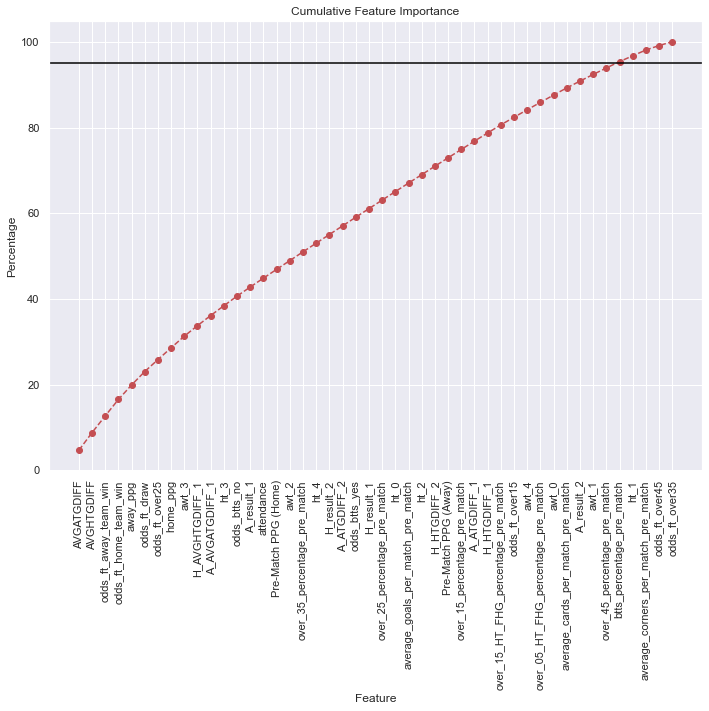

In [16]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
bottom, top = ylim()
bottom = 0
plt.plot(names,cum_values, '--bo', color='r')
# set importance at 95%
plt.axhline(95,color='black')
plt.xticks(rotation=90);
plt.xlabel('Feature'); 
plt.ylabel('Percentage'); 
plt.title('Cumulative Feature Importance');

In [17]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes, labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes=classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             #rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.13333333 0.64       0.22666667]
 [0.01492537 0.92537313 0.05970149]
 [0.0326087  0.2173913  0.75      ]]


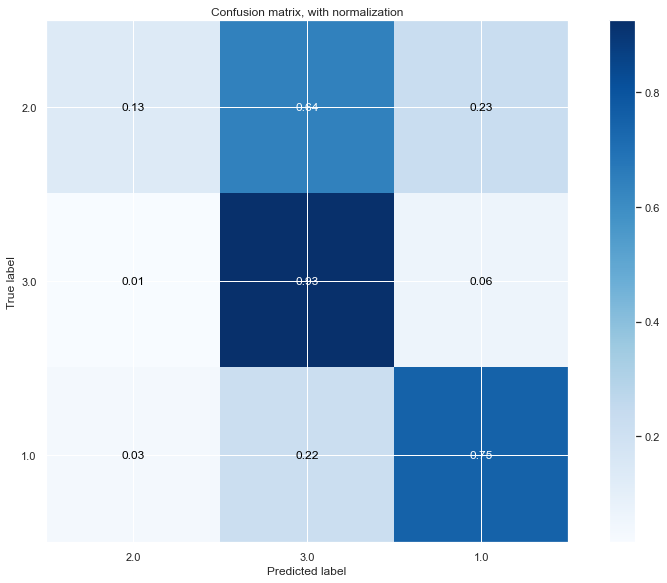

In [18]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=pd.Series(Y).unique(), labels=pd.Series(Y).unique(),
                      title='Confusion matrix, with normalization', normalize=True)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def learning_curve(preds,y_test, model):
    predictions = [round(value) for value in preds]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

Accuracy: 67.44%


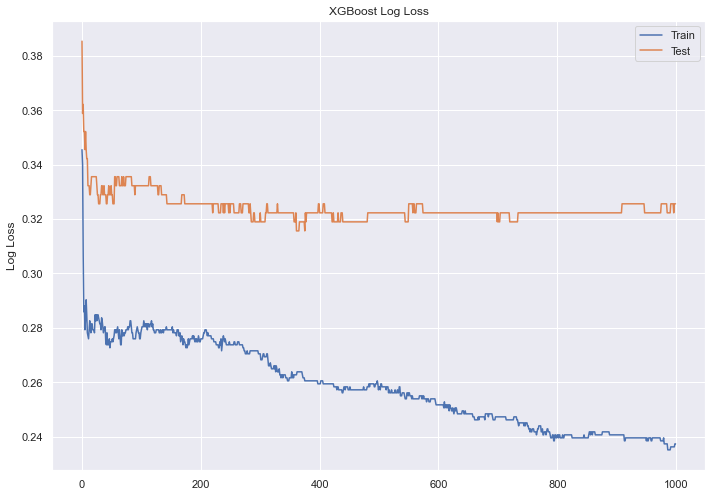

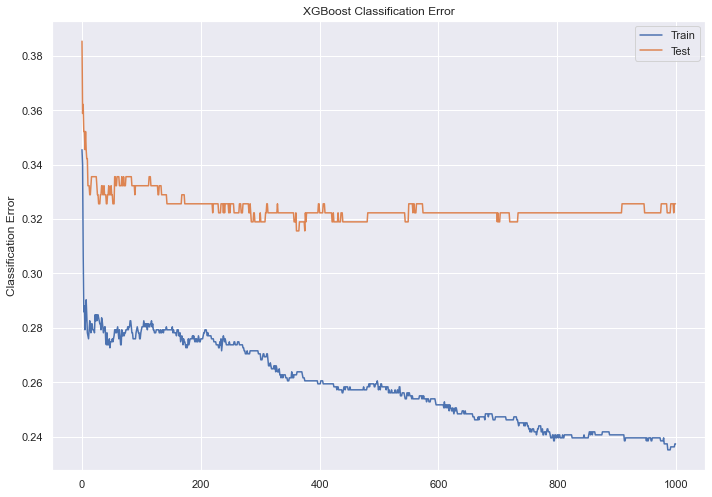

In [20]:
learning_curve(y_pred,y_test,XGB_model)

# TODO CHECK OVERFITTING

## GridSearch 

In [21]:
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from matplotlib import pyplot

# xgb = XGBClassifier(learning_rate=0.005, n_estimators=50, objective='multi:softprob',
#                     silent=True, nthread=1, reg_alpha = 0.2, reg_lambda = .5, gamma=5)

In [22]:
# params = {
#         'min_child_weight': [1, 5, 10,15],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5,6,7],
#         'n_estimators': [400, 800, 1000],
#         'early_stopping_rounds': [3,5,10]
#         }

In [23]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# folds = 4
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=5, cv=skf.split(X,Y), verbose=3, random_state=1001 )

In [24]:
# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [25]:
# from datetime import datetime

# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X, Y)
# timer(start_time) 

In [26]:
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)

In [27]:
# best=random_search.best_params_

# xgb_best = XGBClassifier(
#     silent=False, 
#     objective='multi:softprob',
#     colsample_bytree = best['colsample_bytree'],
#     min_child_weight = best['min_child_weight'],
#     subsample = best['subsample'],
#     n_estimators=best['n_estimators'], 
#     max_depth=best['max_depth'], 
#     seed=82,
#     early_stopping_rounds=best['early_stopping_rounds']
# )


In [28]:
# eval_set = [(X_train, y_train), (X_test, y_test)]
# xgb_best.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)
# y_pred3 = xgb_best.predict(X_test)
# y_pred_train = xgb_best.predict(X_train)
# accuracy = accuracy_score(y_test, y_pred3)
# accuracy_train = accuracy_score(y_train, y_pred_train)

In [29]:
# print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
# print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))

## Predict Result for Next Games

In [30]:
z_pred = XGB_model.predict(Z)

In [31]:
xgb_df_next_games = df_next_games.copy()

In [32]:
xgb_df_next_games['predicted_result'] = z_pred

In [33]:
xgb_df_next_games['R']=False

### Adds FootyStats Odds to predictions

In [34]:
df_all = pd.read_pickle("pickle_files/df_all.pkl")

In [35]:
for index, row in xgb_df_next_games.iterrows():
    odds_home = df_all.loc[index]['odds_ft_home_team_win']
    odds_draw = df_all.loc[index]['odds_ft_draw']
    odds_away = df_all.loc[index]['odds_ft_away_team_win']
    
    xgb_df_next_games.at[index,'odds_ft_home_team_win'] = odds_home
    xgb_df_next_games.at[index,'odds_ft_draw'] = odds_draw
    xgb_df_next_games.at[index,'odds_ft_away_team_win'] = odds_away
    

In [36]:
xgb_df_next_games

,home_team_name,away_team_name,predicted_result,tipico quota,R,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win
1224,Bayern München,Schalke 04,3.0,0,False,1.15,9.25,17.75
1225,Eintracht Frankfurt,Arminia Bielefeld,2.0,0,False,1.69,4.15,5.10
1226,Union Berlin,Augsburg,3.0,0,False,2.25,3.35,3.45
1227,Köln,Hoffenheim,1.0,0,False,2.55,3.70,2.70
1228,Werder Bremen,Hertha BSC,3.0,0,False,2.85,3.50,2.55
1229,Stuttgart,Freiburg,3.0,0,False,2.25,3.45,3.35
1230,Borussia Dortmund,Borussia M'gladbach,3.0,0,False,1.65,4.45,5.05
1231,RB Leipzig,Mainz 05,1.0,0,False,1.39,5.50,7.75
1232,Wolfsburg,Bayer Leverkusen,1.0,0,False,3.05,3.50,2.40


### LR comparisson

In [37]:
lr_z_pred = LR.predict(Z)

In [38]:
lr_df_next_games = df_next_games.copy()

In [39]:
lr_df_next_games['predicted_result'] = lr_z_pred

In [40]:
import sqlite3
# Create your connection.
cnx1 = sqlite3.connect('data1.db')
cnx2 = sqlite3.connect('data2.db')

### Check Before Save in DB

In [41]:
xgb_df_next_games.to_pickle("pickle_files/next_games.pkl")

In [42]:
# xgb_df_next_games.to_sql(name='xgb_df_next_games', con=cnx1,if_exists='append')
# lr_df_next_games.to_sql(name='lr_df_next_games', con=cnx2,if_exists='append')

# Access SQLite DB

### Delete

In [43]:
# def deleteRecord():
#     try:
#         sqliteConnection = sqlite3.connect('data1.db')
#         cursor = sqliteConnection.cursor()
#         print("Connected to SQLite")

#         # Deleting single record now
#         sql_delete_query = """DELETE from xgb_df_next_games where rowid > 9"""
#         cursor.execute(sql_delete_query)
#         sqliteConnection.commit()
#         print("Record deleted successfully ")
#         cursor.close()

#     except sqlite3.Error as error:
#         print("Failed to delete record from sqlite table", error)
#     finally:
#         if (sqliteConnection):
#             sqliteConnection.close()
#             print("the sqlite connection is closed")

# deleteRecord()

### Read

In [44]:
df_xgb = pd.read_sql_query("SELECT * from xgb_df_next_games", cnx1)
df_lr = pd.read_sql_query("SELECT * from lr_df_next_games", cnx2)

# MYSQL

In [45]:
import pandas as pd
import config
#SQL
import mysql.connector 
from mysql.connector import errorcode
from sqlalchemy import create_engine

In [46]:
df = pd.read_pickle("pickle_files/next_games.pkl")

In [47]:
df

,home_team_name,away_team_name,predicted_result,tipico quota,R,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win
1224,Bayern München,Schalke 04,3.0,0,False,1.15,9.25,17.75
1225,Eintracht Frankfurt,Arminia Bielefeld,2.0,0,False,1.69,4.15,5.10
1226,Union Berlin,Augsburg,3.0,0,False,2.25,3.35,3.45
1227,Köln,Hoffenheim,1.0,0,False,2.55,3.70,2.70
1228,Werder Bremen,Hertha BSC,3.0,0,False,2.85,3.50,2.55
1229,Stuttgart,Freiburg,3.0,0,False,2.25,3.45,3.35
1230,Borussia Dortmund,Borussia M'gladbach,3.0,0,False,1.65,4.45,5.05
1231,RB Leipzig,Mainz 05,1.0,0,False,1.39,5.50,7.75
1232,Wolfsburg,Bayer Leverkusen,1.0,0,False,3.05,3.50,2.40


In [48]:
cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        password = config.passwd)
print(cnx)
cursor = cnx.cursor()
#insert Database Name
db_name = 'bookie'

In [49]:
#creates db
# def create_database(cursor, database):
#     try:
#         cursor.execute(
#             "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
#     except mysql.connector.Error as err:
#         print("Failed creating database: {}".format(err))
#         exit(1)
# try:
#     cursor.execute("USE {}".format(db_name))
# except mysql.connector.Error as err:
#     print("Database {} does not exists.".format(db_name))
#     if err.errno == errorcode.ER_BAD_DB_ERROR:
#         create_database(cursor, db_name)
#         print("Database {} created successfully.".format(db_name))
#         cnx.database = db_name
#     else:
#         print(err)
#         exit(1)

In [50]:
engine = create_engine("mysql+mysqlconnector://{user}:{pw}@{host}/{db}"
                       .format(user=config.user,
                               pw=config.passwd,
                               host=config.host,
                               db=config.db_name
                       ))

In [51]:
df.to_sql('bookie', con=engine, if_exists='replace')